# Auditing Bias

## Abstract

I analyze the predicition of employment status and audit for racial bias for residents of Massachussetts in 2023.

In [184]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MA" # My state

data_source = ACSDataSource(survey_year='2023', # Get more recent data
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2023GQ0000077,1,1,503,1,25,1019518,11,89,...,12,13,13,13,13,13,13,12,13,13
1,P,2023GQ0000098,1,1,613,1,25,1019518,11,20,...,3,4,2,20,13,9,2,20,13,2
2,P,2023GQ0000109,1,1,613,1,25,1019518,80,68,...,28,34,78,73,34,68,82,15,17,79
3,P,2023GQ0000114,1,1,801,1,25,1019518,69,21,...,60,74,161,11,127,57,11,12,11,12
4,P,2023GQ0000135,1,1,1201,1,25,1019518,27,84,...,27,28,27,29,27,29,27,27,28,27


In [185]:
# No RELP avaiable 
possible_features=['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,89,16.0,2,1,NaN,1,1.0,4.0,3,1,1,1,1.0,2,1,6.0
1,20,16.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,6.0
2,68,18.0,5,1,NaN,1,1.0,4.0,1,1,1,2,2.0,1,1,6.0
3,21,19.0,5,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,1.0
4,84,16.0,1,1,NaN,1,3.0,4.0,3,1,2,1,1.0,2,1,6.0


## Model

### Feature selection And Data Split

In [186]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [187]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

(73126, 14)
(73126,)
(73126,)


In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

### Basic Descriptives

In [189]:

import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["race"] = group_train
df["label"] = y_train


df.head()


,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,race,label
0,69.0,19.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,False
1,10.0,7.0,5.0,2.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,2.0,1.0,1,False
2,14.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,8,False
3,55.0,1.0,5.0,2.0,0.0,4.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,1,True
4,42.0,23.0,5.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,True


1. The number of indiviuals in this df are

In [190]:
print("The number of indiviuals in this df are", df.shape[0])

The number of indiviuals in this df are 58500


2. The proportion of employed individuals are 

In [191]:
emp = df[df['label'] == True][["label"]].size # 29703
total = df['label'].size # 58500
emp_prop = emp / total
print("The proportion of employed indiviuals are", emp_prop)

The proportion of employed indiviuals are 0.5077435897435898


3. The proportion of employed people in each group are:

In [192]:
df.groupby('race')[['label']].aggregate('mean')

,label
race,
1,0.514687
2,0.473668
3,0.530612
5,0.520000
6,0.540315
7,0.625000
8,0.486364
9,0.456270


4. Intersectional Trends

Text(0, 0.5, 'Employment')

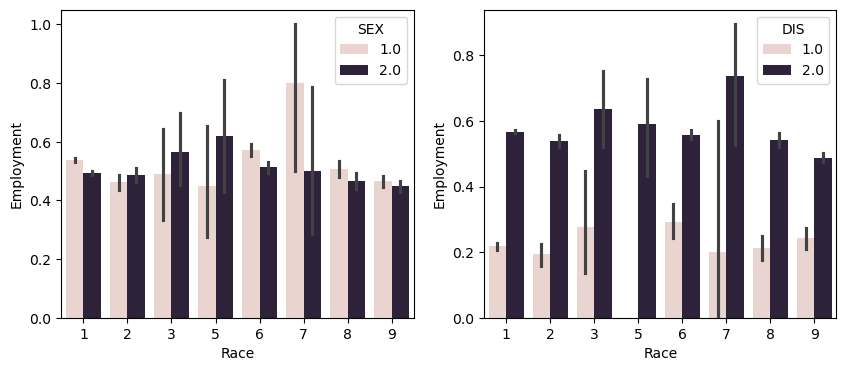

In [193]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

plt1 = sns.barplot(df, x = "race", y = "label", hue="SEX", ax=ax[0])
plt1.set_xlabel("Race")
plt1.set_ylabel("Employment")


plt2 = sns.barplot(df, x = "race", y = "label", hue="DIS", ax=ax[1])
plt2.set_xlabel("Race")
plt2.set_ylabel("Employment")


In this we see intersectionality between sex of the person and whether they have a disability. As we can see in both graphs generally male and able bodied people are more likely to be employed. It is important to recogonize that we also I'm not sure how many of both groups. More females are more likely to be doing childcare at home and depending on disability people may not apply for jobs at all. It is interesting that for American Indians and Alaskan Natives more women are employed than men. 

Text(0, 0.5, 'Employment')

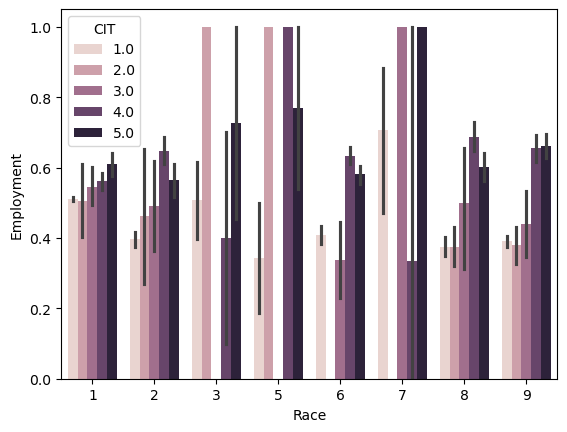

In [194]:
plt2 = sns.barplot(df, x = "race", y = "label", hue="CIT")
plt2.set_xlabel("Race")
plt2.set_ylabel("Employment")


In this graph, we see that for people born in the U.S or it's territories have lower percentage employment than people born abroad or by naturalization. I suspect this is due to population numbers and people who move here for specific work purposes.   

### Training Model

Used a decision tree classifier becauses it is among the easier to interepret and no need to for

In [195]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = {
    'max_depth': [1, 3, 5, 10]
}

model = DecisionTreeClassifier() 
grid = GridSearchCV(model, param_grid, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params", grid.best_params_)

best_dtree = grid.best_estimator_

best_dtree.predict(X_train)
best_dtree.score(X_train, y_train)

Best params {'max_depth': 10}


0.8346495726495726

### Testing model

In [196]:
pred = best_dtree.predict(X_test)


# Bias Audit

### Overall Measures

The overall accuracy:

In [197]:
(pred == y_test).mean()

np.float64(0.8221660057431971)

Here we calculate the PPV, the false negative and false positive rate

In [198]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

ppv = tp / (tp + fp)
fnr = fn / (fn + tp)
fpr = tp / (tp + tn)

print("Overall PPV:", ppv)
print("Overall false negative rate:", fnr)
print("Overall false positive rate:", fpr)


Overall PPV: 0.7942300579459992
Overall false negative rate: 0.12639001898562516
Overall false positive rate: 0.5357172557172557


### By-Group Measures

This is the accuracy by group:

In [372]:
groups = df["race"].unique()
table = pd.DataFrame(groups, columns=["race"])

accuracies = []
for group in groups:
   accuracy = (pred == y_test)[group_test == group].mean()
   accuracies.append(accuracy)

table["accuracy"] = accuracies
table


,race,accuracy
0,1,0.824527
1,8,0.807092
2,9,0.825095
3,2,0.798479
4,6,0.821859
5,7,0.500000
6,5,1.000000
7,3,0.843750


This is the PPV, the false negative and false positive rate by group:

In [373]:
ppvs = []
tprs = []
tnrs = []

fnrs = []
fprs = []

for group in groups:
    tp = int(0)
    fp = int(0)
    tn = int(0)
    fn = int(0)
    for n, m, grp in zip(y_test, pred, group_test):
        if(grp == group):
            if m == n:
                if n == True:
                    tp += 1
                if n == False:
                    tn += 1
            if m != n:
                if n == True:
                    fn += 1
                if n == False:
                    fp += 1
    ppv = ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    ppvs.append(ppv)
    fnr = fn / (fn + tp)  if (fn + tp) > 0 else 0
    fnrs.append(fnr)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fprs.append(fpr)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tprs.append(tpr)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    tnrs.append(tnr)
    

table["ppv"] = ppvs
table["tpr"] = tprs
table["tnr"] = tnrs
table["fpr"] = fprs
table["fnr"] = fnrs
table.set_index("race", inplace=True)
table.sort_index(inplace=True)
table



,accuracy,ppv,tpr,tnr,fpr,fnr
race,,,,,,
1,0.824527,0.802766,0.869107,0.778226,0.221774,0.130893
2,0.798479,0.739030,0.874317,0.732861,0.267139,0.125683
3,0.843750,0.666667,1.000000,0.772727,0.227273,0.000000
5,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.821859,0.807588,0.901664,0.716567,0.283433,0.098336
7,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000
8,0.807092,0.750630,0.889552,0.732432,0.267568,0.110448
9,0.825095,0.769345,0.873311,0.785615,0.214385,0.126689


### Bias Measures

Approximately calibrated:

In [222]:
cal = pd.DataFrame(pred)
cal["prediction"] = pred
print(pred.size)
cal.groupby(0).count()

14626


,prediction
0,
False,6515
True,8111


This table shows that values either True or False, therefore they this model is calibrated.

Approximate error balance rate: Looking at the table dataframe above we can see that the model does not meet approximate error rate balance for groups.

Statistical parity:

In [223]:
probs = []
for group in groups:
    prob = int(0)
    prob = (pred == True)[group_test == group].mean()
    probs.append(prob)

ind = pd.DataFrame(groups, columns=["race"])
ind["prob"] = probs
ind.set_index("race", inplace=True)
ind.sort_index(inplace=True)
ind

,prob
race,
1,0.551568
2,0.548796
3,0.468750
5,0.000000
6,0.635112
7,0.000000
8,0.563121
9,0.511027


The model does not meet statistical parity.

$$
\begin{aligned}
    \mathrm{FPR} = \frac{p}{1-p}\frac{1 - \mathrm{PPV}}{\mathrm{PPV}}\left(1 - \mathrm{TPR}\right) \;. 
\end{aligned}
$$

$$
\begin{aligned}
    p = \left(1 + \frac{\mathrm{TPR}}{\mathrm{FPR}} \frac{1 - \mathrm{PPV}}{\mathrm{PPV}}\right)^{-1}\;. 
\end{aligned}
$${#eq-rearranged-for-p}

In [374]:
table.reset_index(inplace=True)
print(table)

   race  accuracy       ppv       tpr       tnr       fpr       fnr
0     1  0.824527  0.802766  0.869107  0.778226  0.221774  0.130893
1     2  0.798479  0.739030  0.874317  0.732861  0.267139  0.125683
2     3  0.843750  0.666667  1.000000  0.772727  0.227273  0.000000
3     5  1.000000  0.000000  0.000000  1.000000  0.000000  0.000000
4     6  0.821859  0.807588  0.901664  0.716567  0.283433  0.098336
5     7  0.500000  0.000000  0.000000  1.000000  0.000000  1.000000
6     8  0.807092  0.750630  0.889552  0.732432  0.267568  0.110448
7     9  0.825095  0.769345  0.873311  0.785615  0.214385  0.126689


In [ ]:
table["prevalance"] = (1 + (table["tpr"] / table["fpr"]) * ((1 - table["ppv"])/(table["ppv"]))) ** -1
table["prevalance"] = table["prevalance"].fillna(0)

print(new)

   race  accuracy       ppv       tpr       tnr       fpr       fnr  \
0     1  0.824527  0.802766  0.869107  0.778226  0.221774  0.130893   
1     2  0.798479  0.739030  0.874317  0.732861  0.267139  0.125683   
2     3  0.843750  0.666667  1.000000  0.772727  0.227273  0.000000   
3     5  1.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
4     6  0.821859  0.807588  0.901664  0.716567  0.283433  0.098336   
5     7  0.500000  0.000000  0.000000  1.000000  0.000000  1.000000   
6     8  0.807092  0.750630  0.889552  0.732432  0.267568  0.110448   
7     9  0.825095  0.769345  0.873311  0.785615  0.214385  0.126689   

   prevalance  
0    0.509466  
1    0.463878  
2    0.312500  
3    0.000000  
4    0.568847  
5    0.000000  
6    0.475177  
7    0.450190  


In [388]:
table['race'] = table['race'].replace({1: "White", 2: "Black", 3: "Native American", 4:"Native Alaskan", 
                      5:"SPAA", 
                      6:'Asian', 7: 'NPI', 8:'Other', 9: 'Multi'})

table['race'] = pd.Categorical(table['race'])
new = table.copy(True)
# print(new.dtypes)

new

,race,accuracy,ppv,tpr,tnr,fpr,fnr,prevalance
0,White,0.824527,0.802766,0.869107,0.778226,0.221774,0.130893,0.509466
1,Black,0.798479,0.739030,0.874317,0.732861,0.267139,0.125683,0.463878
2,Native American,0.843750,0.666667,1.000000,0.772727,0.227273,0.000000,0.312500
3,SPAA,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4,Asian,0.821859,0.807588,0.901664,0.716567,0.283433,0.098336,0.568847
5,NPI,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
6,Other,0.807092,0.750630,0.889552,0.732432,0.267568,0.110448,0.475177
7,Multi,0.825095,0.769345,0.873311,0.785615,0.214385,0.126689,0.450190


ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 8 and the vector passed to `x` has length 1.

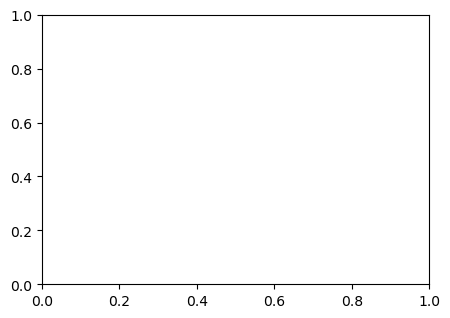

In [394]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3.5))

ppv = 0.5
p = new['prevalance'].mean()

fpr_values = np.linspace(0, 1, 1) 
fnr_values = np.linspace(0, 1, 1)

def feasible_fnr(fpr, ppv, p):
    fnr = (ppv * (1 - fpr) - p * (1 - ppv)) / (1 - ppv * (1 - fpr))
    return fnr

fpr_grid = np.linspace(0, 1, 8)
fnr_grid = np.array([feasible_fnr(fpr, ppv, p) for fpr in fpr_grid])

for race in table['race'].unique():
    # Calculate the prevalence (p) for each race (optional if you want race-specific prevalences)
    p_race = table[table['race'] == race]['prevalance'].values[0]  # Take the prevalence for that race
    
    # Calculate the feasible FN rates (FNR) for each FPR based on ppv and prevalence
    fnr_values = [feasible_fnr(fpr, ppv, p_race) for fpr in fpr_values]
    sns.lineplot(new,x=fpr_values, y=fnr_values, label=race)
    
# sns.scatterplot(data=new, x="fpr", y="fnr", hue="race", palette='Set1', ax=ax, s=100, marker="o")
# plot.set_yticks([0, 0.25, 0.5, 0.75, 1])
# plot.set_xticks([0, 0.25, 0.5, 0.75, 1])

